In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline

In [44]:
data = pd.read_csv('/home/artem/Projects/wolf_of_crunchbase/data.csv')


/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (6,13,15,16,17,24,39,44,59,64,69,74,79,84,94,99,104,109,114) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<H3>Data preparation</H3>

<H4>Set ipo information to NaN if ipo was after acquisition</H4>

In [45]:
ipo_fields = ['ipo_id', 'valuation_amount', 'valuation_currency_code', 'raised_amount', 'raised_currency_code', 
              'public_at', 'stock_symbol']
ipo = pd.DataFrame({'ipo': data.public_at, 'acquired': data.acquired_at})
ipo.dropna(how='any', inplace=True)
ipo.loc[:, 'ipo'] = ipo.ipo.apply(pd.to_datetime)
ipo.loc[:, 'acquired'] = ipo.acquired.apply(pd.to_datetime)
ipo['ipo_after_acquired'] = (ipo['ipo'] - ipo['acquired']).apply(lambda x: x.days > 0)
indexes = ipo[ipo['ipo_after_acquired'] == True].index
data.loc[indexes, ipo_fields] = np.nan

<H4>Set closed_at to NaN if closed after acquisition</H4>

In [46]:
closed = pd.DataFrame({'closed': data.closed_at, 'acquired': data.acquired_at})
closed.dropna(how='any', inplace=True)
closed.loc[:, 'closed'] = closed.closed.apply(pd.to_datetime)
closed.loc[:, 'acquired'] = closed.acquired.apply(pd.to_datetime)
closed['closed_after_acquired'] = (closed['closed'] - closed['acquired']).apply(lambda x: x.days > 0)
indexes = closed[closed['closed_after_acquired'] == True].index
data.loc[indexes, 'closed_at'] = np.nan

<H4>Remove extra data and make some features</H4>

In [47]:
data['ipo'] = data.ipo_id.notnull()
data['is_acquired'] = data.acquired_at.notnull()
data['is_closed'] = data.closed_at.notnull()
data['age'] = (pd.to_datetime('2014-01-01') - pd.to_datetime(data['founded_at'])).apply(lambda x: x.days)
data.loc[:, 'category_code'] = data.category_code.astype('category')
columns_to_drop = ['Unnamed: 0', 'name', 'company_id', 'ipo_id', 'founded_at', 'closed_at']
data.drop(columns_to_drop, inplace=True, axis=1)

<H3>Columns in data file</H3>

In [8]:
for column in data.columns:
    print(column)

category_code
status
country_code
state_code
city
region
valuation_amount
valuation_currency_code
raised_amount
raised_currency_code
public_at
stock_symbol
acquired_at
b_funded_at
b_raised_amount_usd
b_pre_money_valuation_usd
b_post_money_valuation_usd
b_participants
angel_funded_at
angel_raised_amount_usd
angel_pre_money_valuation_usd
angel_post_money_valuation_usd
angel_participants
a_funded_at
a_raised_amount_usd
a_pre_money_valuation_usd
a_post_money_valuation_usd
a_participants
seed_funded_at
seed_raised_amount_usd
seed_pre_money_valuation_usd
seed_post_money_valuation_usd
seed_participants
c_funded_at
c_raised_amount_usd
c_pre_money_valuation_usd
c_post_money_valuation_usd
c_participants
d_funded_at
d_raised_amount_usd
d_pre_money_valuation_usd
d_post_money_valuation_usd
d_participants
unattributed_funded_at
unattributed_raised_amount_usd
unattributed_pre_money_valuation_usd
unattributed_post_money_valuation_usd
unattributed_participants
debt_round_funded_at
debt_round_raised_amo

In [9]:
print("Total companies: ", data.shape[0])
print("Total features: ", data.shape[1])
print("Share of acquired companies: ", data.is_acquired.mean())

Total companies:  196704
Total features:  117
Share of acquired companies:  0.0483721734179


<H3>Testing data assumption</H3>

Columns 'age' and 'category_code' seem as important features. Let's test this assumption.

<H4>Probability of company acquisition depending on age (splitting by five years)</H4>
Also count of companies of each age is located below.

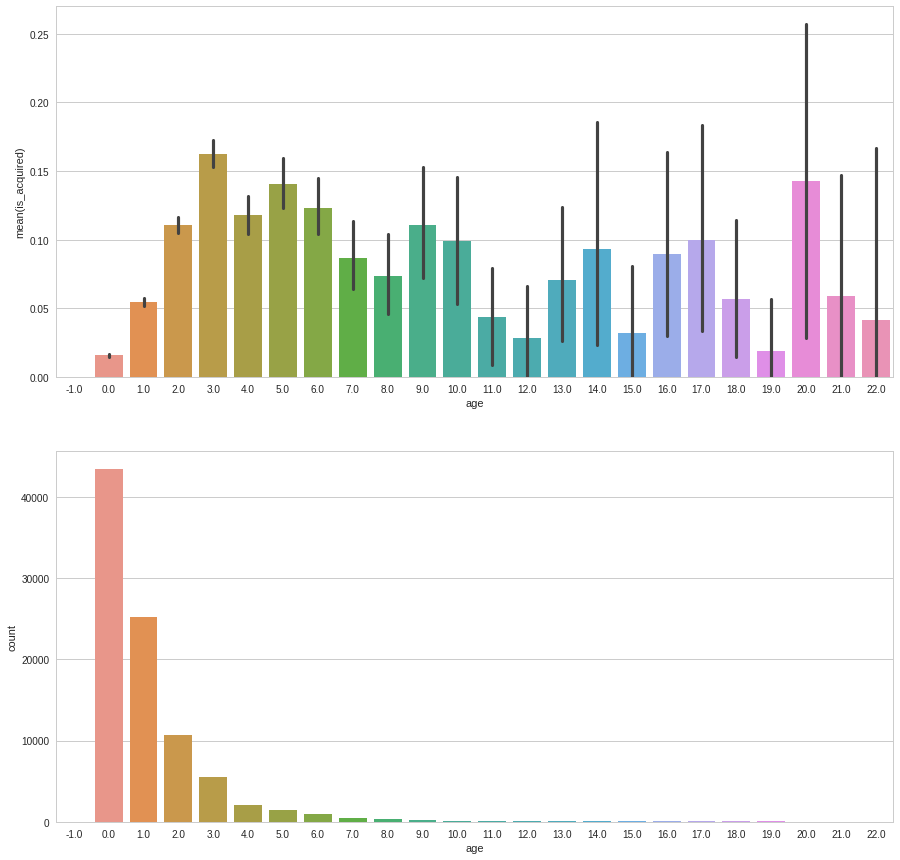

In [10]:
age_acquisition = pd.DataFrame({'age': data.age.apply(lambda x: x // (365 * 5))})
age_acquisition['is_acquired'] = data.is_acquired
fig, axs = plt.subplots(2, 1, figsize=(15,15))
sns.barplot(x='age', y='is_acquired', data=age_acquisition, ax=axs[0])
sns.countplot(x='age', data=age_acquisition[age_acquisition['age'].notnull()], ax=axs[1])



<H4>Probability of company acquisition depending on company category</H4>

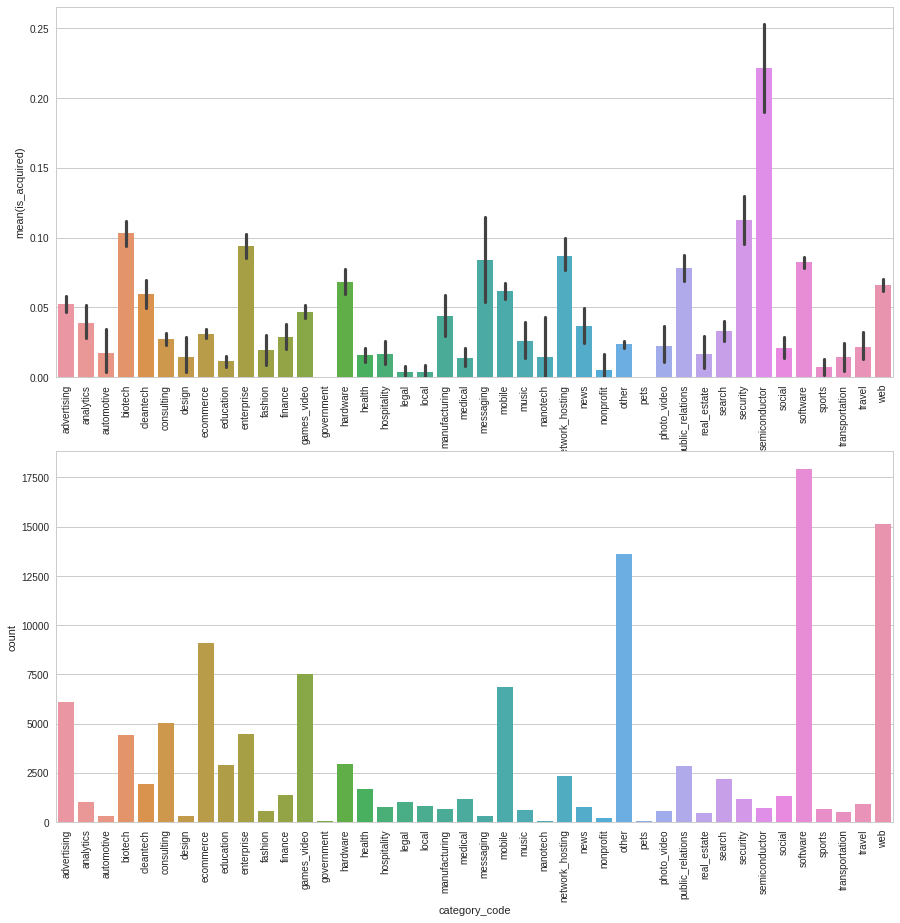

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
p1 = sns.barplot(x='category_code', y='is_acquired', data=data, ax=axs[0])
p2 = sns.countplot(x='category_code', data=data, ax=axs[1])
for plot in [p1, p2]:
    for item in plot.get_xticklabels():
        item.set_rotation(90)

In [12]:
data.groupby(by='category_code').is_acquired.mean().sort_values(ascending=False)

category_code
semiconductor       0.221264
security            0.112245
biotech             0.103114
enterprise          0.093729
network_hosting     0.087049
messaging           0.084175
software            0.082195
public_relations    0.078136
hardware            0.068405
web                 0.065932
mobile              0.061435
cleantech           0.059248
advertising         0.052080
games_video         0.046734
manufacturing       0.044118
analytics           0.039101
news                0.036411
search              0.032967
ecommerce           0.031071
finance             0.028860
consulting          0.027556
music               0.025818
other               0.023488
photo_video         0.022059
travel              0.021368
social              0.020611
fashion             0.019538
automotive          0.017182
hospitality         0.016927
real_estate         0.016878
health              0.015901
transportation      0.014315
nanotech            0.014286
design              0.014235


<H3>Share of non-null data in each column</H3>

In [13]:
data.notnull().mean().sort_values(ascending=False)

is_closed                                    1.000000
is_acquired                                  1.000000
ipo                                          1.000000
status                                       1.000000
region                                       1.000000
category_code                                0.626901
age                                          0.464337
country_code                                 0.447947
city                                         0.427109
state_code                                   0.259258
seed_participants                            0.051499
seed_funded_at                               0.051061
unattributed_participants                    0.049475
unattributed_funded_at                       0.049272
acquired_at                                  0.048372
unattributed_raised_amount_usd               0.042439
seed_raised_amount_usd                       0.040645
a_participants                               0.038098
a_funded_at                 

As we can see there is a big number of columns which have small fullness. Those columns which have 100% fullness are categorical, so there is no possibility to extract usefull information directly from them. I suggest to create new features based on existing. For example, was_{round} = true if company was funded at {round}. Or there may be another approach for it: we can use {round}_participants and set {round}_participants = 0 if company was not funded at {round}. 

<H3>Data correlation</H3>

But let's look at the correlation between numeric columns:

In [14]:
corrmat = data[data.dtypes[data.dtypes == np.float64].index].corr()
corrmat

,valuation_amount,raised_amount,b_raised_amount_usd,b_pre_money_valuation_usd,b_post_money_valuation_usd,b_participants,angel_raised_amount_usd,angel_pre_money_valuation_usd,angel_post_money_valuation_usd,angel_participants,...,g_participants,secondary_market_raised_amount_usd,secondary_market_pre_money_valuation_usd,secondary_market_post_money_valuation_usd,secondary_market_participants,crowd_equity_raised_amount_usd,crowd_equity_pre_money_valuation_usd,crowd_equity_post_money_valuation_usd,crowd_equity_participants,age
valuation_amount,1.000000,0.994552,0.034215,NaN,NaN,0.226182,-1.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.053796
raised_amount,0.994552,1.000000,0.010206,NaN,NaN,0.153801,NaN,NaN,NaN,1.000000,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.384865
b_raised_amount_usd,0.034215,0.010206,1.000000,0.872853,0.582704,0.241413,0.457808,1.000000,0.402629,0.299071,...,0.360946,1.0,NaN,NaN,-0.114673,NaN,NaN,NaN,NaN,0.029238
b_pre_money_valuation_usd,NaN,NaN,0.872853,1.000000,0.996246,-0.026134,-0.639824,NaN,NaN,-0.151327,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.075100
b_post_money_valuation_usd,NaN,NaN,0.582704,0.996246,1.000000,0.462632,0.664186,NaN,NaN,0.630952,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.156818
b_participants,0.226182,0.153801,0.241413,-0.026134,0.462632,1.000000,0.146946,NaN,0.631044,0.398152,...,0.670874,1.0,NaN,NaN,-0.294102,NaN,NaN,NaN,NaN,0.000355
angel_raised_amount_usd,-1.000000,NaN,0.457808,-0.639824,0.664186,0.146946,1.000000,0.472915,0.204218,0.080525,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.201118
angel_pre_money_valuation_usd,NaN,NaN,1.000000,NaN,NaN,NaN,0.472915,1.000000,-0.261826,0.481077,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.551160
angel_post_money_valuation_usd,NaN,NaN,0.402629,NaN,NaN,0.631044,0.204218,-0.261826,1.000000,-0.042225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.187893
angel_participants,NaN,1.000000,0.299071,-0.151327,0.630952,0.398152,0.080525,0.481077,-0.042225,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.054726


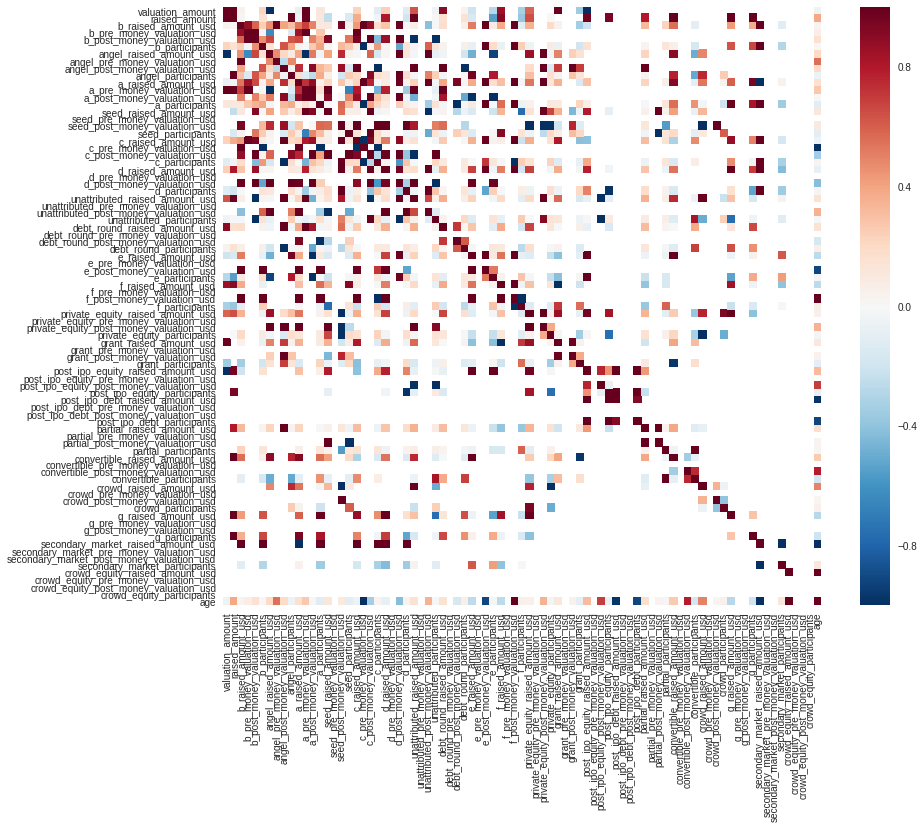

In [15]:
f, ax = plt.subplots(figsize=(14, 11))
sns.heatmap(corrmat, vmax=.8, square=True);

Columns which have the absolute value of correlation between them more than 0.6

In [16]:
threshold = 0.6
index = corrmat.index
for i in range(len(index)):
    for j in range(i + 1, len(index)):
        corr_value = corrmat.loc[index[i], index[j]]
        if abs(corr_value) > threshold and corr_value != 1:
            print("%s <-> %s: %s" % (index[i], index[j], corr_value))
    
    

valuation_amount <-> raised_amount: 0.994551768605
valuation_amount <-> angel_raised_amount_usd: -1.0
valuation_amount <-> unattributed_raised_amount_usd: 0.632402232222
valuation_amount <-> debt_round_raised_amount_usd: 0.899794706115
valuation_amount <-> f_raised_amount_usd: 0.854394480812
valuation_amount <-> grant_raised_amount_usd: 0.989149313097
valuation_amount <-> post_ipo_equity_raised_amount_usd: -1.0
raised_amount <-> d_raised_amount_usd: 0.811102860111
raised_amount <-> unattributed_raised_amount_usd: 0.986356291555
raised_amount <-> f_raised_amount_usd: 0.912203851352
raised_amount <-> private_equity_raised_amount_usd: 0.647419332096
raised_amount <-> post_ipo_equity_raised_amount_usd: 0.961131353848
raised_amount <-> post_ipo_equity_participants: 0.950303909275
raised_amount <-> partial_raised_amount_usd: 0.797854367206
b_raised_amount_usd <-> b_pre_money_valuation_usd: 0.872853462479
b_raised_amount_usd <-> a_pre_money_valuation_usd: 0.686417745343
b_raised_amount_usd <-

As shown above, there is a lot of columns which have strong correlation between them, but it can be explained. The more some company was funded, for example, at round A, the more it will be funded at round B. The strong correlation is one more reason to make new features.

<H3>Making new features</H3>

Let's test the first approach: binary features inicating some round was or not.

In [48]:
codes = ['b', 'angel', 'a', 'seed', 'c', 'd', 'unattributed', 'debt_round', 'e', 'f', 'private_equity', 'grant', 'post_ipo_equity', 'post_ipo_debt', 'partial', 'convertible', 'crowd', 'g', 'secondary_market', 'crowd_equity']
suffixes = ['funded_at', 'raised_amount_usd', 'pre_money_valuation_usd', 'post_money_valuation_usd', 'participants']
columns = ["%s_%s" % (code, suff) for code in codes for suff in suffixes]
invested_companies = data[data[columns].any(axis=1)]
len(invested_companies)

31666

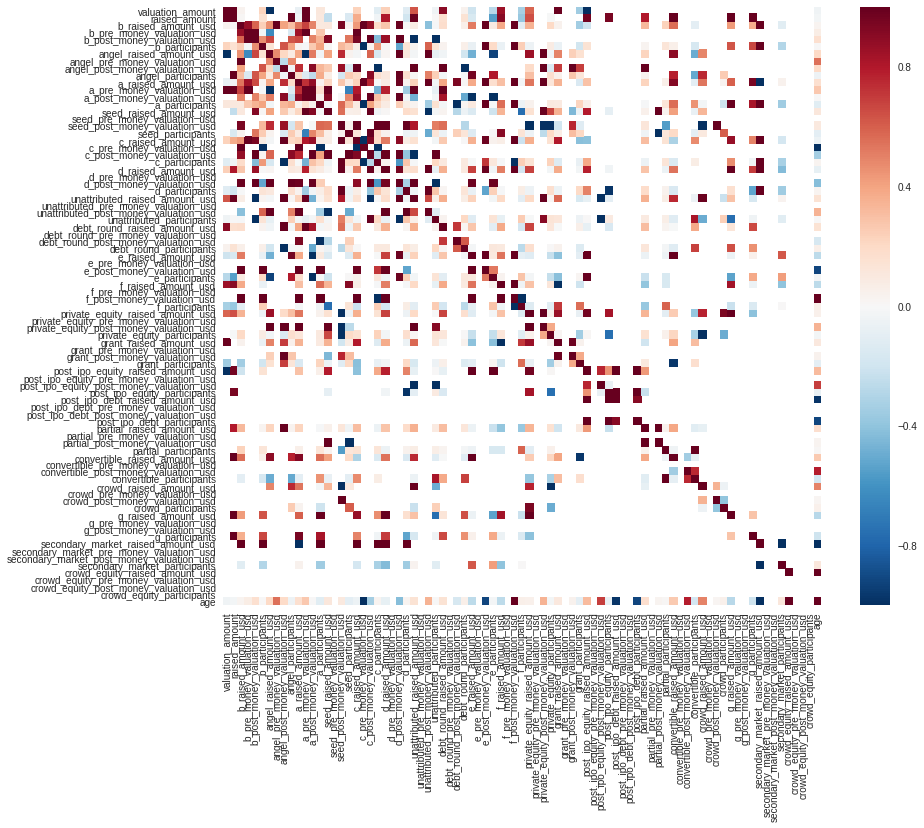

In [39]:
corrmat = invested_companies[invested_companies.dtypes[data.dtypes == np.float64].index].corr()
f, ax = plt.subplots(figsize=(14, 11))
sns.heatmap(corrmat, vmax=.8, square=True);

In [51]:
invested_companies.to_csv('/home/artem/Projects/wolf_of_crunchbase/invested_companies.csv', index=False)

In [50]:
invested_companies.index

Int64Index([     0,      3,      4,      5,      7,     10,     11,     12,
                13,     14,
            ...
            196655, 196674, 196675, 196676, 196677, 196678, 196679, 196680,
            196689, 196703],
           dtype='int64', length=31666)